## Fisher Information Matrix

The Fisher information matrix can be defined as $F_{ij}[h] = (h_{i}, h_{j})$ where $h_{i}$ is the partial derivative of $h(f)$ with respect to the i-th parameter $\theta_{i}$ and "( , )" denotes an inner product weighted by the expected PSD of detector noise, such as:

$$
(h, g) = 4 \cdot Re[\int_{0}^{\infty} \frac{h(f)^{*}g(f)}  {S_{n}(f)} df].
$$

The Fisher matrix can also be represented as 

$$
F_{ij} = \langle \partial_{i} \log p(s | \theta_{0}), \partial_{j} \log p(s | \theta_{0}) \rangle_{n},
$$
which, under certain conditions, is equivalent to

$$
F_{ij} = -\langle \partial_{i} \partial_{j} \log p(s | \theta_{0}) \rangle_{n}.
$$

We represent an average over the probability distribution of noise as "$\langle \cdot \rangle_{n}$", and

$$
\langle u(s), v(s)\rangle_{n} = \int u(s) v(s) p(s | \theta_{0}) ds.
$$

For a posterior $p(\theta_{0} | s)$ sufficiently close to the true source parameter $\theta_{0}$, under the assumption of Gaussian noise and in the high SNR limit, the inverse of the Fisher matrix can be interpreted as the covariance matrix for the posterior probability distribution.


Adapted (a.k.a. occasionally taken word-for-word) from https://arxiv.org/pdf/gr-qc/0703086v2.pdf

In [75]:
from __future__ import division

import numpy
import lal
import lalsimulation
from lalinference.rapid_pe import lalsimutils
import matplotlib.pyplot as plt
from scipy import interpolate


In [76]:
def generate_waveform(m_chirp, eta):
    """
    Generate a generic TaylorF2 waveform given a chirp mass and symmetric mass ratio
    using a TaylorF2 appriximation for binaries with zero spin.
    
    m_chirp -- chirp mass 
    
    eta -- symmetric mass ratio
    
    Returns:
    h1 -- magnitude of h_plus and h_cross in the frequency domain
    """
    
    # Generate a waveform following the same procedure in waveform_overlap.ipynb
    m1, m2 = lalsimutils.m1m2(m_chirp, eta)
    #print m1, m2, m_chirp
    m1 *= lal.MSUN_SI
    m2 *= lal.MSUN_SI
    s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.0, 0.0, 0.0
    coa_phase, polarization_angle = 0.0, 0.0
    ra, dec = 0.0, 0.0
    dist, incl = 1e6 * lal.PC_SI, 0.0
    flow = 30
    fmax = 2048
    delta_f = 0.125
    # TaylorT2, TaylorT4, TaylorF2, SEOBNRv1, SEOBNRv2, IMRPhenomP, IMRPhenomPv2
    #approx1 = lalsimulation.IMRPhenomPv2  #TaylorF2
    approx1 = lalsimulation.IMRPhenomPv2  #TaylorF2

    hpf, hxf = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                                m1, m2,
                                s1x, s1y, s1z,
                                s2x, s2y, s2z,
                                flow, fmax, flow,
                                dist, 0.0, incl,
                                0.0, 0.0, None, None,
                                0, -1, approx1)
    #print hpf.f0, hpf.deltaF, len(hpf.data.data)

    # For convenience, we'll reuse hpf and redefine to be h1
    hpf.data.data += hxf.data.data
    h1 = hpf
    return h1.data.data

In [77]:
# Assign necessary variables and define the overlap object

# Bounds of the integral -- we consider anything outside of these bounds to be effectively zero because of the
# waveform terminating or the detector sensitivity being too small
flow = 30
fmax = fnyq = 2048

# We're actually doing a numerical integral so df -> \delta f
delta_f = 0.125

flow_index = flow/delta_f

# Define the overlap object
olap = lalsimutils.Overlap(flow, fmax, fnyq, delta_f)



For a constant eta, generate 40 waveforms at different m_chirps. Waveforms are stored in a numpy array.

In [78]:
# Pick a constant eta
eta = 0.2

# Iterate over a set of different chirp masses and calculate h(f) for each chirp mass
delta_mc = 1  # Solar masses
mcs = numpy.arange(1, 40, delta_mc)
waveforms = []
waveform_data = []
for mc in mcs:
    waveforms.append(generate_waveform(mc, eta))
waveforms = numpy.asarray(waveforms)

Calculate an array of frequencies corresponding to h(f). This frequency list is common for all generated waveforms.

Question: Is there a way to extract this array from SimInspiralFD?

In [79]:
#freqs_waveform = []
#for index in numpy.arange(len(waveforms[0])):
#    freqs_waveform.append(flow + delta_f*index)
#freqs_waveform = numpy.asarray(freqs_waveform)

freqs_waveform = numpy.arange(0, 2048 + delta_f, delta_f)

# FIX ME: maybe an easier way to do with by defining a lambda function or something but this 
# seemed convenient since I need the frequencies in an array of length len(waveforms[0])

## Calculate $\frac{\partial h(f)}{\partial M_{c}}$

I have now generated an h(f) for several different values of $M_{c}$.

For each h(f), I will calculate $\frac{\partial h(M_{i}, f_{j})}{\partial M_{c}}$ numerically, at each value of $f$, by the following equation

$$
\frac{\partial h(M_{i}, f_{j})}{\partial M_{c}} = \frac{h(M_{i+1}, f_{j}) - h(M_{i}, f_{j})}{\Delta M_{c}},
$$
for each chirp mass i, at each frequency j.

0 3.09676683981e-21
1 6.58858436014e-21
2 3.76884474773e-21
3 2.23676502844e-21
4 1.46907150735e-21
5 1.03583316247e-21
6 7.67801625063e-22
7 5.9043483135e-22
8 4.66971732864e-22
9 3.77590454279e-22
10 3.10828568874e-22
11 3.94061100109e-22
12 2.19651737279e-22
13 1.87771985655e-22
14 1.61994067176e-22
15 1.4087751919e-22
16 1.23383121122e-22
17 1.08745647455e-22
18 9.63913948904e-23
19 8.58833304856e-23
20 7.68837471196e-23
21 6.91283432116e-23
22 6.24078385981e-23
5173 16385


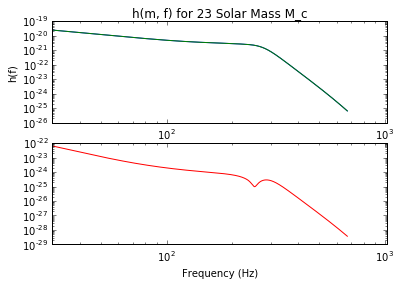

23 1.22411397215e-21
4949 16385


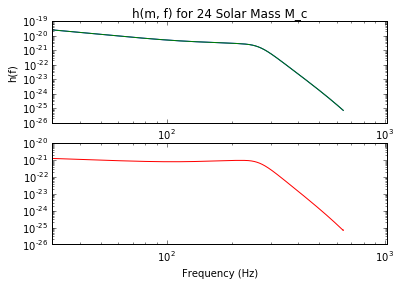

24 5.14339659599e-23
4744 16385


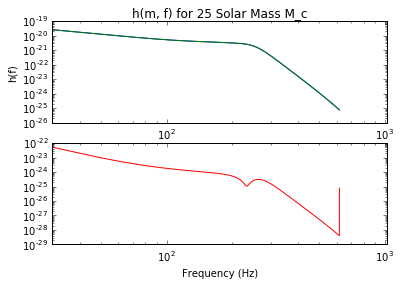

25 4.69351112663e-23
4554 16385


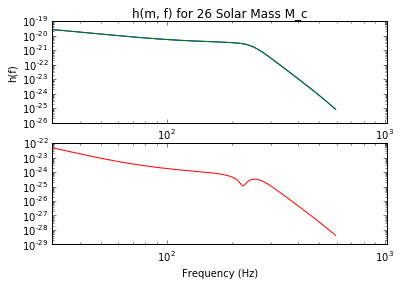

26 4.29677056161e-23
27 3.94568200249e-23
28 3.6340028261e-23
29 3.14976132461e-21
30 3.10876053709e-23
31 2.88704258515e-23
32 2.68815570144e-23
33 2.50937209793e-23
34 2.34834549467e-23
35 2.20304760261e-23
36 2.07175575348e-23
37 1.95294581779e-23


In [80]:
waveform_derivs = []
# Iterate over each M_chirp and get the waveform (h(f)) at each M_chirp
for waveform_index in numpy.arange(len(waveforms) - 1):
    waveform_deriv = []
    waveform = waveforms[waveform_index]

    
    # Find the h(f_index) for the next chirp mass value
    # next_waveform = waveforms[waveform_index + 1]
    # FIX ME: I had this as + 0.001 before
    mc_close = mcs[waveform_index] + 0.001  # Make calculations at a very close value of M_chirp
    waveform_close = generate_waveform(mc_close, eta)
    
    
    # For a given h(f) iterate over each frequency value and calculate derivative
    for freq_index, freq in enumerate(waveform):
        waveform_deriv.append((waveform_close[freq_index] - waveform[freq_index]) / delta_mc)
        if freq_index == int(30/0.125):
            print waveform_index, numpy.abs(waveform_deriv[-1])
    waveform_derivs.append(numpy.asarray(waveform_deriv))
    
    if waveform_index in (22, 23, 24, 25):
        print numpy.count_nonzero(numpy.abs(waveform)), len(waveform)
        plt.subplot(2,1,1)
        plt.plot(freqs_waveform, numpy.abs(waveform_close), 'b')
        plt.plot(freqs_waveform, numpy.abs(waveform), 'g')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('h(f)')
        plt.title('h(m, f) for %i Solar Mass M_c' % (waveform_index + 1))
        plt.xlim(flow, 1024)
        plt.ylim(1e-26, 1e-19)
        plt.loglog()

        plt.subplot(2,1,2)
        plt.plot(freqs_waveform, numpy.abs(waveform_derivs[waveform_index]), 'r')
        plt.xlabel('Frequency (Hz)')
        #plt.ylabel("h'(f)")
        #plt.title('Partial of h(m, f) with respect to M_c')
        plt.xlim(flow, 1024)
        plt.loglog()
        plt.show()
    
waveform_derivs = numpy.asarray(waveform_derivs)

  

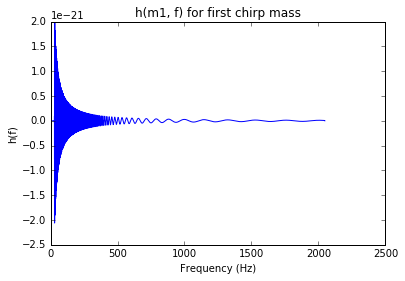

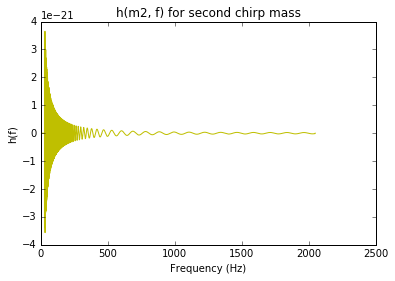

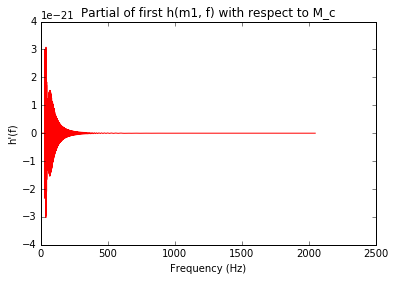

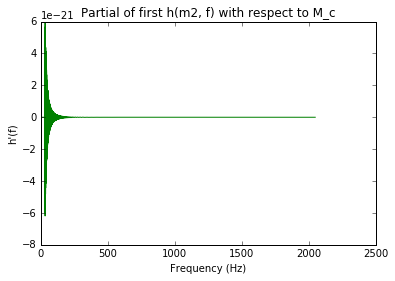

In [81]:
# Plot some stuff as a brief sanity check

plt.figure(1)
plt.plot(freqs_waveform, waveforms[0], 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('h(f)')
plt.title('h(m1, f) for first chirp mass')

plt.figure(2)
plt.plot(freqs_waveform, waveforms[1], 'y')
plt.xlabel('Frequency (Hz)')
plt.ylabel('h(f)')
plt.title('h(m2, f) for second chirp mass')

plt.figure(3)
plt.plot(freqs_waveform, waveform_derivs[0], 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel("h'(f)")
plt.title('Partial of first h(m1, f) with respect to M_c')

plt.figure(4)
plt.plot(freqs_waveform, waveform_derivs[1], 'g')
plt.xlabel('Frequency (Hz)')
plt.ylabel("h'(f)")
plt.title('Partial of first h(m2, f) with respect to M_c')
plt.show()

Get a PSD for one detector. Organize the PSD so we can easily access sensitivity values of a desired frequency.

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


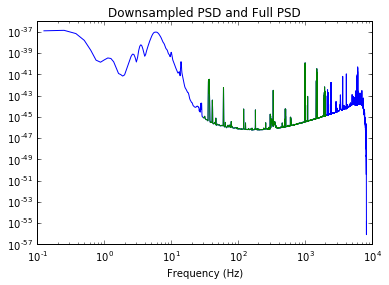

In [82]:
# Get a PSD to weight the Fisher matrix
frequencies, psd = numpy.loadtxt("H1-GDS-CALIB_STRAIN.txt", unpack=True)
df = frequencies[1] - frequencies[0]  
psd *= psd

# Interpolate a function for PSD as a function of frequency
freq_func = interpolate.interp1d(frequencies, psd)

plt.loglog(frequencies, psd)
plt.loglog(freqs_waveform[flow_index:], freq_func(freqs_waveform[flow_index:]))
plt.xlabel('Frequency (Hz)')
plt.title('Downsampled PSD and Full PSD')
plt.show()

## Fisher Matrix

Use the following equation to calculate the Fisher matrix value for each M_chirp at which a waveform was generated.

$$
\Gamma_{i} = 4 \cdot Re[\int_{30}^{2048} \frac{\frac{\partial h(M_{i}, f_{j})}{\partial M_{c}}^{*} \frac{\partial h(M_{i}, f_{j})}{\partial M_{c}}}  {S_{n}(f)} df].
$$


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


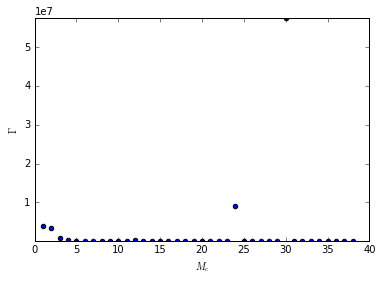

In [83]:
# Calculate the Fisher matrix for each m_chirp with psd
fisher = []
for deriv in waveform_derivs:
    # FIX ME: more efficient way to incorporate the flow_index
    fisher.append(4 * numpy.real(numpy.sum(
                deriv[flow_index:] * numpy.conjugate(deriv[flow_index:]) / freq_func(freqs_waveform[flow_index:]) ) * delta_f))

plt.scatter(mcs[:-1], numpy.asarray(fisher))
plt.xlim([0, None])
plt.ylim(min(fisher), max(fisher))
plt.xlabel(r'$M_c$')
plt.ylabel(r'$\Gamma$')
plt.show()


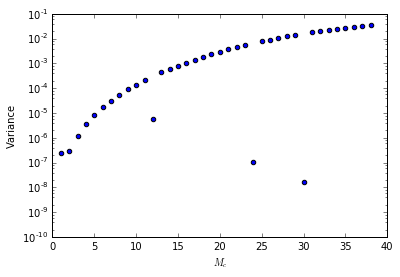

[182.9432009118361, 9097882.1318789162, 128.52887122079892] [9097882.1318789162, 57617185.373669438]
8.8234504675e-21
1.86165721848e-18
7.48617503189e-21


In [84]:
# Calculate the inverse of the Fisher matrix
plt.scatter(mcs[:-1], 1./numpy.asarray(fisher))
plt.xlim([0, None])
#plt.ylim(min(fisher), max(fisher))
plt.xlabel(r'$M_c$')
plt.ylabel('Variance')
#plt.ylim(0, 5e-3)
plt.semilogy()
plt.ylim(1e-10, 1e-1)
plt.savefig('plots/Fisher_IMRPhenomPv2.png')
plt.show()

print fisher[22:25], sorted(fisher)[-2:]
print numpy.sum(numpy.abs(waveform_derivs[22]))
print numpy.sum(numpy.abs(waveform_derivs[23]))
print numpy.sum(numpy.abs(waveform_derivs[24]))

## Investigate Outliers

The Fisher Matrix shows one large outlier at 24 solar masses that requires investigation. This outlier mainly exists when derivatives are calculated from waveforms of an M_chirp differing by 0.001. Different outliers emerge with different M_chirp derivative intervals.

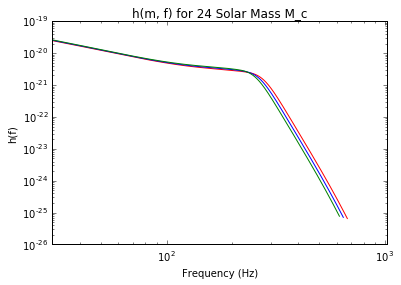

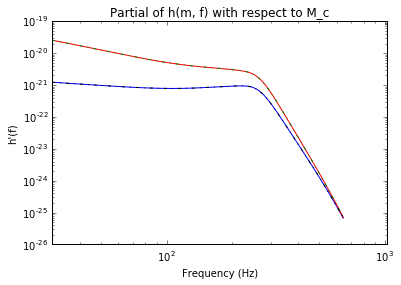

24
(45.61376096990143, 17.42290633578898)


In [85]:
# Make some plots

outlier_index = 23

plt.figure(1)
plt.plot(freqs_waveform, numpy.abs(waveforms[outlier_index - 1]), 'r')
plt.plot(freqs_waveform, numpy.abs(waveforms[outlier_index]), 'b')
plt.plot(freqs_waveform, numpy.abs(waveforms[outlier_index + 1]), 'g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('h(f)')
plt.title('h(m, f) for %i Solar Mass M_c' % (outlier_index + 1))
plt.xlim(flow, 1024)
plt.ylim(1e-26, 1e-19)
plt.loglog()

plt.figure(2)
plt.plot(freqs_waveform, numpy.abs(waveform_derivs[outlier_index]), 'b')
h = generate_waveform(24, eta)
h2 = generate_waveform(24 + 1e-3, eta)
plt.plot(freqs_waveform, numpy.abs(h), 'r')
plt.plot(freqs_waveform, numpy.abs(h2), 'g-.')
plt.plot(freqs_waveform, numpy.abs(h2-h), 'k-.')

plt.xlabel('Frequency (Hz)')
plt.ylabel("h'(f)")
plt.title('Partial of h(m, f) with respect to M_c')
plt.xlim(flow, 1024)
plt.loglog()
plt.show()

print mcs[outlier_index]
print lalsimutils.m1m2(mcs[outlier_index], eta)

Investigating the effect of different derivative calculation methods on the Fisher Matrix.

In [86]:
def calculate_deriv(mc_difference, waveforms, eta, delta_mc):
    waveform_derivs = []
    #print waveforms
    # Iterate over each M_chirp and get the waveform (h(f)) at each M_chirp
    for waveform_index in numpy.arange(len(waveforms) - 1):
        waveform_deriv = []
        waveform = waveforms[waveform_index]


        # Find the h(f_index) for the next chirp mass value
        # next_waveform = waveforms[waveform_index + 1]
        # FIX ME: I had this as + 0.001 before
        mc_close = mcs[waveform_index] + mc_difference  # Make calculations at a very close value of M_chirp
        waveform_close = generate_waveform(mc_close, eta)


        # For a given h(f) iterate over each frequency value and calculate derivative
        for freq_index, freq in enumerate(waveform):
            waveform_deriv.append((waveform_close[freq_index] - waveform[freq_index]) / delta_mc)
        waveform_derivs.append(numpy.asarray(waveform_deriv))

    return numpy.asarray(waveform_derivs)
    


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


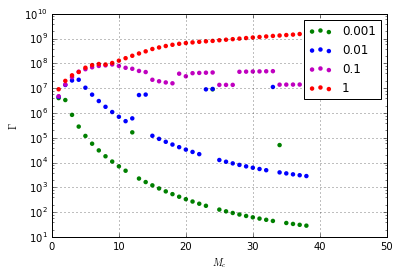

In [87]:
#print waveforms
#print len(waveforms)
colors = ['r', 'm', 'b', 'g']
for mc_difference in [0.001, 0.01, 0.1, 1]:
    derivs = calculate_deriv(mc_difference, waveforms, eta, delta_mc)
    fisher = []
    for deriv in derivs:
        # FIX ME: more efficient way to incorporate the flow_index
        fisher.append(4 * numpy.real(numpy.sum(
                    deriv[flow_index:] * numpy.conjugate(deriv[flow_index:]) / freq_func(
                    freqs_waveform[flow_index:]) ) * delta_f))
    plt.scatter(mcs[:-1], numpy.asarray(fisher), label=mc_difference, c=colors.pop(), edgecolors='None')

plt.grid()
plt.legend(loc="upper right")
plt.xlim(0, None)
#plt.ylim(1e2, None)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$\Gamma$')
plt.semilogy()
plt.show()

